In [1]:
# We would like to plot the solution space of Wang 2018 for a given set of variables.
# To do so, we first call the solution of Wang 2018 and then solve for a an array of varibles and plot

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
import mpmath as mp
from scipy.signal import savgol_filter
from scipy.special import kv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def omega_fn(PERIOD):
    params = 2 * np.pi / PERIOD
    return params

def betta_fn(K_LE, K_AQ, B_AQ, B_LE, omega, S_AQ):
    params = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5
    return params

def argument_fn(omega, S_AQ, B_AQ, K_LE, B_LE):
    params = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)
    return params

def tide_fn(SKEMPTON, BULK, E_0):
    params = (SKEMPTON * BULK * E_0) / 1E4
    return params

def xi_fn(R_W, R_C, omega, K_AQ, B_AQ, betta):
    params = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2
    return params

def h_w_fn(argument, tide, xi):
    params = argument * tide / xi
    return params

def drawdown_fn(omega, R_C, h_w, betta, K_AQ, B_AQ, R):
    params = -(1j * omega * R_C ** 2 * h_w * kv(0, betta * R)) / (2 * K_AQ * B_AQ * betta * R_W * kv(1, betta * R))
    return params

def flux_fn(omega, h_w,  R_C):
    params = omega * np.absolute(h_w) * np.pi * R_C**2 *1E3
    return params

def Wang(K_AQ, S_AQ, K_LE):
    
    R_W = 0.2 # well radius m
    R_C = 0.2 # well case m
    R = 0.2 # distance from the well m (only for drawdown computation)
    PERIOD = np.arange(1,2) * 24 * 3600 / 2 # s
    B_AQ = 1 # Aquifer depth m
    B_LE = 100 # Leaky layer depth m
    SKEMPTON = 0.5 # Skempton's coefficient [-]
    BULK = 20000000000.0 # Undrained bulk modulus [Pa] (computed in the above cell)
    
    E_0 = 1E-7 # Signal amplitude [-] (this amplitude is unrealistic, but convinient for this example)
    
    omega = omega_fn(PERIOD)
    betta = betta_fn(K_LE, K_AQ, B_AQ, B_LE, omega, S_AQ)
    argument = argument_fn(omega, S_AQ, B_AQ, K_LE, B_LE)
    tide = tide_fn(SKEMPTON, BULK, E_0)
    xi = xi_fn(R_W, R_C, omega, K_AQ, B_AQ, betta)
    h_w = h_w_fn(argument, tide, xi)
    amp = h_w / tide
    shift = np.angle(h_w / tide, deg=True)
    opt_amplitude = amp.real
    opt_shift = shift.real
    
    return opt_amplitude, opt_shift

Now we define the array of variables we would like to solve for

In [6]:
#%% define matrix variables
K_lim = [1e-10, 1e-2] # permeability
Ss_lim = [1E-8, 1e-3] # storage

x = np.logspace(np.log10(K_lim[0]), np.log10(K_lim[1]), 100)
y = np.logspace(np.log10(Ss_lim[0]), np.log10(Ss_lim[1]), 100)
X, Y = np.meshgrid(x, y)

#%% evaluate the functions
w_amp_01, w_phase_01 = Wang(X, Y, 0)
w_amp_02, w_phase_02 = Wang(X, Y, 1E-6)
w_amp_03, w_phase_03 = Wang(X, Y, 1E-5)
w_amp_04, w_phase_04 = Wang(X, Y, 1E-4)

S_v = np.logspace(-8, -3, 100)
A_v = np.tile(S_v, (100, 1))

w_amp_01_v = A_v*w_amp_01
w_amp_02_v = A_v*w_amp_02
w_amp_03_v = A_v*w_amp_03
w_amp_04_v = A_v*w_amp_04

amp_min = np.min([w_amp_01.min(), w_amp_04.min()])
amp_max = np.max([w_amp_01.max(), w_amp_04.max()])

# Save results
data = 'data/'
np.savetxt(data + 'w_amp_01.csv', w_amp_01, delimiter=',')
np.savetxt(data + 'w_amp_02.csv', w_amp_02, delimiter=',')
np.savetxt(data + 'w_amp_03.csv', w_amp_03, delimiter=',')
np.savetxt(data + 'w_amp_04.csv', w_amp_04, delimiter=',')

np.savetxt(data + 'w_phase_01.csv', w_phase_01, delimiter=',')
np.savetxt(data + 'w_phase_02.csv', w_phase_02, delimiter=',')
np.savetxt(data + 'w_phase_03.csv', w_phase_03, delimiter=',')
np.savetxt(data + 'w_phase_04.csv', w_phase_04, delimiter=',')

Now we just need to plot

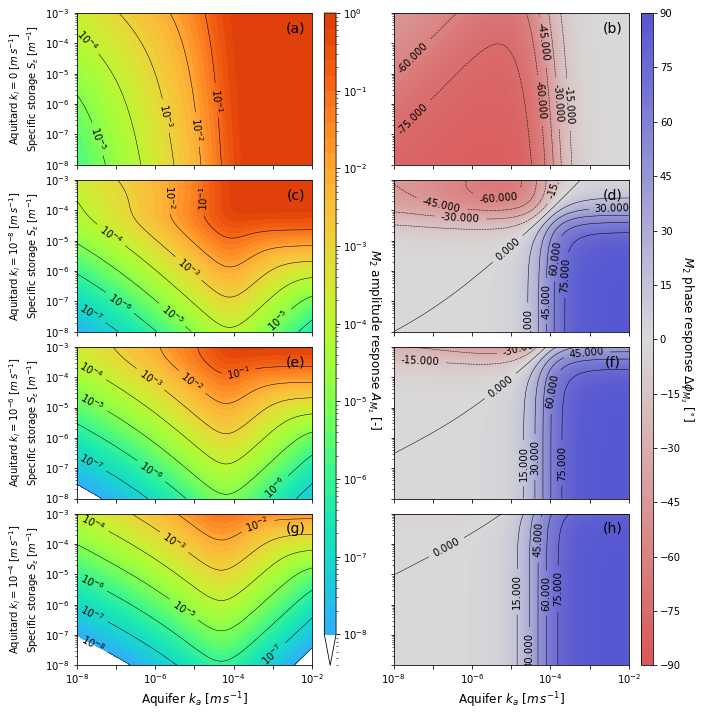

In [9]:
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap

### Read data
w_amp_01 = np.genfromtxt('data/w_amp_01.csv', delimiter=',') # leakage = 0
w_amp_02 = np.genfromtxt('data/w_amp_02.csv', delimiter=',') # leakage = 1E-6
w_amp_03 = np.genfromtxt('data/w_amp_03.csv', delimiter=',') # leakage = 1E-5
w_amp_04 = np.genfromtxt('data/w_amp_04.csv', delimiter=',') # leakage = 1E-4

w_phase_01 = np.genfromtxt('data/w_phase_01.csv', delimiter=',') # leakage = 0
w_phase_02 = np.genfromtxt('data/w_phase_02.csv', delimiter=',') # leakage = 1E-6
w_phase_03 = np.genfromtxt('data/w_phase_03.csv', delimiter=',') # leakage = 1E-5
w_phase_04 = np.genfromtxt('data/w_phase_04.csv', delimiter=',') # leakage = 1E-4

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#%% colormaps
# %matplotlib auto
cmap1 = plt.get_cmap('turbo')
cmap1 = truncate_colormap(cmap1, 0.15, 0.85)
cmap1.set_under('w')

grey = [0.85,0.85,0.85]
white = [1, 1, 1]
blue = [0, 0, 205/255]
red = [(220/255), 0, 0]

cmap = LinearSegmentedColormap.from_list("reds", [red, grey, blue], N=256)
cmap2 = truncate_colormap(cmap, 0.2, 0.8)

#%% Figure size
fig = plt.figure(figsize=(8, 12), facecolor='white')

levelsampf = np.logspace(-8, 0, 41)
levelsampl = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1E-4, 1E-3, 1E-2, 1E-1, 1])

levelsphsf = np.linspace(-90, 90, 181)
levelsphsl = np.array([-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90])
levels_p = levelsphsl

ka_levels = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
ka_labels = ['$10^{-8}$', '', '$10^{-6}$','',  '$10^{-4}$', '', '$10^{-2}$']

# Generate grid
K_lim = [1e-8, 1e-2] # permeability
Ss_lim = [1E-8, 1e-3] # storage
x = np.logspace(np.log10(K_lim[0]), np.log10(K_lim[1]), w_phase_01.shape[0])
y = np.logspace(np.log10(Ss_lim[0]), np.log10(Ss_lim[1]), w_phase_01.shape[0])
X, Y = np.meshgrid(x, y)

# Now we look for the max and min values to plot since we want to plot in log scale
amp_min = np.min([w_amp_01.min(), w_amp_02.min(), w_amp_03.min(), w_amp_04.min()])

amp_max = np.max([w_amp_01.max(), w_amp_02.max(), w_amp_03.max(), w_amp_04.max()])

#%% first column
gs1 = gridspec.GridSpec(4, 2, width_ratios=[20, 1])
gs1.update(left=0, right=0.45, wspace=0.1, hspace=0.1)

#%% second column
gs2 = gridspec.GridSpec(4, 2, width_ratios=[20, 1])
gs2.update(left=0.55, right=1, wspace=0.1, hspace=0.1)

#%% Plot amplitude leakage = 0
ax1 = plt.subplot(gs1[0,0])
ax1.set_xscale("log")
ax1.set_yscale("log")
# cplot1 = ax1.pcolormesh(X, Y, w_amp_01, cmap=cmap1, norm=LogNorm(vmin=amp_min, vmax=amp_max), shading='auto',linewidth=0,rasterized=True)
cplot1 = ax1.contourf(X, Y, w_amp_01, levels=levelsampf, cmap=cmap1, norm=LogNorm(vmin=amp_min, vmax=amp_max))
cplot = ax1.contour(X, Y, w_amp_01, levels=levelsampl, linewidths=0.5, colors='k')

# Format the labels so it has the same type than the other figures
fmt = {}
strs = [ r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', '$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$']#,r'$10^{-7}$',r'$10^{-6}$',r'$10^{-5}$']
for l,s in zip( cplot.levels, strs ):
    fmt[l] = s
# Label every other level using strings
ax1.clabel(cplot, cplot.levels, inline=True, fmt=fmt, fontsize=10, manual=False)

# From here is just to make it pretty
ax1.set_ylabel("Aquitard $k_{l} = 0$ [$m\,s^{-1}$]\nSpecific storage $S_{\epsilon}$ [$m^{-1}$]")
ax1.set_xticks(ka_levels)
ax1.set_xticklabels([])
ax1.set_xlim([np.min(x), np.max(x)])
ax1.set_ylim([np.min(y), np.max(y)])
ax1.text(0.93, 0.9,"(a)", ha='center', va='center', color='k', transform=ax1.transAxes, fontsize=14)

#########################################################################

#%% Plot phase leakage = 0

ax2 = plt.subplot(gs2[0,0])
ax2.set_xscale("log")
ax2.set_yscale("log")
# cplot2 = ax2.pcolormesh(X, Y, w_phase_01, cmap=cmap2, vmin=-90, vmax=90, shading='auto',linewidth=0, rasterized=True)
cplot2 = ax2.contourf(X, Y, w_phase_01, cmap=cmap2, levels=levelsphsf, vmin=-90, vmax=90)
cplot = ax2.contour(X, Y, w_phase_01, levels=levels_p, linewidths=0.5, colors='k')
ax2.clabel(cplot,cplot.levels,inline=True,fontsize=10,manual=False)

# From here is just to make it pretty
ax2.set_yticklabels([])
ax2.set_xticks(ka_levels)
ax2.set_xticklabels([])
ax2.set_xlim([np.min(x), np.max(x)])
ax2.set_ylim([np.min(y), np.max(y)])
ax2.text(0.93, 0.9,'(b)', ha='center', va='center', color='k', transform=ax2.transAxes, fontsize=14)

#########################################################################


#%% Plot amplitude leakage = 1E-6

ax3 = plt.subplot(gs1[1,0])
ax3.set_xscale("log")
ax3.set_yscale("log")

# Countour plot
cplot1 = ax3.contourf(X, Y, w_amp_02, levels=levelsampf, cmap=cmap1, norm=LogNorm(vmin=amp_min, vmax=amp_max))
cplot = ax3.contour(X, Y, w_amp_02, levels=levelsampl, linewidths=0.5, colors='k')

# Format the labels so it has the same type than the other figures
ax3.clabel(cplot,cplot.levels,inline=True,fmt=fmt,fontsize=10,manual=False)

# From here is just to make it pretty
ax3.set_xticks(ka_levels)
ax3.set_xticklabels([])
ax3.set_ylabel("Aquitard $k_{l} = 10^{-8}$ [$m\,s^{-1}$]\nSpecific storage $S_{\epsilon}$ [$m^{-1}$]")
ax3.set_xlim([np.min(x), np.max(x)])
ax3.set_ylim([np.min(y), np.max(y)])
ax3.text(0.93, 0.9,r'(c)', ha='center', va='center', color='k', transform=ax3.transAxes, fontsize=14)

#########################################################################

#%% Plot phase leakage = 1E-6

ax4 = plt.subplot(gs2[1,0])
ax4.set_xscale("log")
ax4.set_yscale("log")

# Countour plot
cplot2 = ax4.contourf(X, Y, w_phase_02, cmap=cmap2, levels=levelsphsf, vmin=-90, vmax=90)
cplot = ax4.contour(X, Y, w_phase_02, levels=levels_p, linewidths=0.5, colors='k')
ax4.clabel(cplot,cplot.levels,inline=True,fontsize=10,manual=False)

# From here is just to make it pretty

ax4.set_yticklabels([])
ax4.set_xticks(ka_levels)
ax4.set_xticklabels([])
ax4.set_xlim([np.min(x), np.max(x)])
ax4.set_ylim([np.min(y), np.max(y)])
ax4.text(0.93, 0.9,r'(d)', ha='center', va='center', color='k', transform=ax4.transAxes, fontsize=14)


#########################################################################

#%% Plot amplitude leakage = 1E-5

#%% Wang model amplitude
ax5 = plt.subplot(gs1[2,0])
ax5.set_xscale("log")
ax5.set_yscale("log")

# Countour plot
cplot1 = ax5.contourf(X, Y, w_amp_03, levels=levelsampf, cmap=cmap1, norm=LogNorm(vmin=amp_min, vmax=amp_max))
cplot = ax5.contour(X, Y, w_amp_03, levels=levelsampl, linewidths=0.5, colors='k')
ax5.clabel(cplot,cplot.levels,inline=True,fmt=fmt,fontsize=10,manual=False)

# From here is just to make it pretty

ax5.set_xticks(ka_levels)
ax5.set_xticklabels([])
ax5.set_ylabel("Aquitard $k_{l} = 10^{-6}$ [$m\,s^{-1}$]\nSpecific storage $S_{\epsilon}$ [$m^{-1}$]")
ax5.set_xlim([np.min(x), np.max(x)])
ax5.set_ylim([np.min(y), np.max(y)])
ax5.text(0.93, 0.9,r'(e)', ha='center', va='center', color='k', transform=ax5.transAxes, fontsize=14)


#########################################################################

#%% Plot phase leakage = 1E-5

ax6 = plt.subplot(gs2[2,0])
ax6.set_xscale("log")
ax6.set_yscale("log")
cplot2 = ax6.contourf(X, Y, w_phase_03, cmap=cmap2, levels=levelsphsf, vmin=-90, vmax=90)
cplot = ax6.contour(X, Y, w_phase_03, levels=levels_p, linewidths=0.5, colors='k')
ax6.clabel(cplot,cplot.levels,inline=True,fontsize=10,manual=False)

# From here is just to make it pretty

ax6.set_yticklabels([])
ax6.set_xticks(ka_levels)
ax6.set_xticklabels([])
ax6.set_xlim([np.min(x), np.max(x)])
ax6.set_ylim([np.min(y), np.max(y)])
ax6.text(0.93, 0.9,r'(f)', ha='center', va='center', color='k', transform=ax6.transAxes, fontsize=14)

#########################################################################
#%% Plot amplitude leakage = 1E-4

ax7 = plt.subplot(gs1[3,0])
ax7.set_xscale("log")
ax7.set_yscale("log")

cplot1 = ax7.contourf(X, Y, w_amp_04, levels=levelsampf, cmap=cmap1, norm=LogNorm(vmin=amp_min, vmax=amp_max), extend='min')
cplot = ax7.contour(X, Y, w_amp_04, levels=levelsampl, linewidths=0.5, colors='k')
ax7.clabel(cplot,cplot.levels,inline=True,fmt=fmt,fontsize=10,manual=False)

# From here is just to make it pretty
ax7.set_ylabel("Post-strain response \n Specific storage $S_s$ [$m^{-1}$]")
ax7.set_xticks(ka_levels)
ax7.set_xticklabels(ka_labels)
ax7.set_xlabel("Aquifer $k_a$ [$m\,s^{-1}$]", fontsize=12)
ax7.set_ylabel("Aquitard $k_{l} = 10^{-4}$ [$m\,s^{-1}$]\nSpecific storage $S_{\epsilon}$ [$m^{-1}$]")
ax7.set_xlim([np.min(x), np.max(x)])
ax7.set_ylim([np.min(y), np.max(y)])
ax7.text(0.93, 0.9,'(g)', ha='center', va='center', color='k', transform=ax7.transAxes, fontsize=14)

#########################################################################

#%% Plot phase leakage = 1E-4

ax8 = plt.subplot(gs2[3,0])
ax8.set_xscale("log")
ax8.set_yscale("log")
cplot2 = ax8.contourf(X, Y, w_phase_04, cmap=cmap2, levels=levelsphsf, vmin=-90, vmax=90)
cplot = ax8.contour(X, Y, w_phase_04, levels=levels_p, linewidths=0.5, colors='k')
ax8.clabel(cplot,cplot.levels,inline=True,fontsize=10,manual=False)

# From here is just to make it pretty
ax8.set_yticklabels([])
ax8.set_xticks(ka_levels)
ax8.set_xticklabels(ka_labels)
ax8.set_xlabel("Aquifer $k_a$ [$m\,s^{-1}$]", fontsize=12)
ax8.set_xlim([np.min(x), np.max(x)])
ax8.set_ylim([np.min(y), np.max(y)])
ax8.text(0.93, 0.9,r'(h)', ha='center', va='center', color='k', transform=ax8.transAxes, fontsize=14)

#%% colorbar 1
cb1 = plt.subplot(gs1[:,1])
cbar1 = fig.colorbar(cplot1, cax=cb1, orientation='vertical', ticks=levelsampl)
cbar1.set_label('$M_2$ amplitude response $A_{M_2}$ [-]', rotation=-90, labelpad=15, fontsize=12)

#%% colorbar 2
cb2 = plt.subplot(gs2[:,1])
cbar2 = fig.colorbar(cplot2, cax=cb2, orientation='vertical', ticks=levels_p)
cbar2.set_label('$M_2$ phase response $\Delta \phi_{M_2}$ [$^{\circ}$]', rotation=-90, labelpad=15, fontsize=12)

# plt.show()
plt.savefig('Figure_3' + '.png', dpi=300, bbox_inches='tight')
plt.savefig('Figure_3' + '.pdf', bbox_inches='tight')
